<a href="https://colab.research.google.com/github/LMAPcoder/Advanced-Computer-Vision/blob/main/DL_variational_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational AutoEncoder (VAE)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchsummary import summary

CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter. CelebA has large diversities, large quantities, and rich annotations, including - 10,177 number of identities, - 202,599 number of face images, and - 5 landmark locations, 40 binary attributes annotations per image.

In [2]:
#-From Google Drive large file

!gdown 'https://drive.google.com/uc?id=1RA49LMpMqtw3pByIkZnTbDnpolOsjtm4' -O celeb_a.zip

Downloading...
From (original): https://drive.google.com/uc?id=1RA49LMpMqtw3pByIkZnTbDnpolOsjtm4
From (redirected): https://drive.google.com/uc?id=1RA49LMpMqtw3pByIkZnTbDnpolOsjtm4&confirm=t&uuid=2a7c80c7-966b-4c63-b461-6114cd127754
To: /content/celeb_a.zip
100% 1.43G/1.43G [00:53<00:00, 26.8MB/s]


In [3]:
!#unziping the file
!unzip -q celeb_a.zip

In [4]:
#Transformation to apply while generating the data
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize (size =(179, 179)),
    torchvision.transforms.ToTensor() ,]
                                                  )

#Getting data from folder
dataset = ImageFolder(root="/content/img_align_celeba/", transform=train_transforms)

print("Dataset size:", len(dataset))

Dataset size: 202599


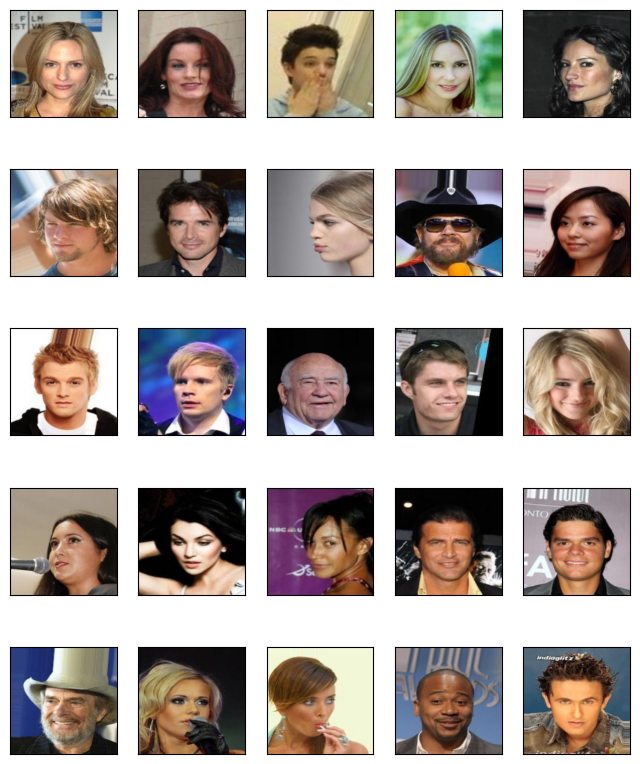

In [25]:
#Printing a random subset of training dataset along with the labels
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(8,10))
for i in range(5):
  for j in range(5):
    idx = np.random.randint(len(dataset))
    img, _ = dataset[idx]
    ax[i,j].imshow(img.permute(1, 2, 0))
    ax[i,j].axes.yaxis.set_visible(False)
    ax[i,j].axes.xaxis.set_visible(False)

plt.show()

In [12]:
#We split the train dataset into a train and test dataset
split_ratio = 0.8
N = len(dataset)
N_train = int(N*split_ratio)
train_ds, test_ds = torch.utils.data.random_split(dataset, [N_train, N-N_train])
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2) #parallelization of data loading
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

Model

Variational Autoencoders (VAEs) are a class of generative models that combine deep learning with variational inference to generate complex data distributions, such as images, audio, and text.

Introduced by Kingma and Welling in 2013, VAEs are an extension of traditional autoencoders, which are neural networks designed to learn efficient, low-dimensional representations of data.

A VAE consists of two main components:

* **Encoder Network**: The encoder takes an input data point (e.g., an image) and maps it to a lower-dimensional latent space. Unlike traditional autoencoders that map inputs directly to latent variables, VAEs parameterize the latent space using a mean vector $\mu$ and a variance vector $\sigma^2$, assuming that the latent variables follow a Gaussian distribution. This allows VAEs to model uncertainty and variability in the latent space.

* **Decoder Network**: The decoder takes a sample from the latent space and attempts to reconstruct the original input. The decoder learns to transform the latent variable back into the original data distribution.

The VAE is particularly notable for its ability to learn a continuous latent space, which is useful for generating new samples that are not just copies of the training data.

The multivariate normal distribution (also known as a Gaussian distribution) is the most commonly used distribution for the latent space in VAEs.

A more flexible alternative to a single Gaussian distribution is a mixture of Gaussians. This approach allows the latent space to model more complex, multimodal distributions, capturing multiple clusters or modes in the data.

In [6]:
# ENCODER

class Encoder(torch.nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()

        self.convA = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=2, padding=1)
        self.convB = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=0)

        self._calculate_conv_output_size()

        self.linear = torch.nn.Linear(in_features=self.flattened_size, out_features=latent_dim)

    def _calculate_conv_output_size(self):
        dummy_input = torch.zeros(1, 3, 179, 179)
        x = self.convA(dummy_input)
        x = self.convB(x)
        self.flattened_size = x.numel()

        return x.size

    def forward(self, z):
        z = self.convA(z)
        z = self.convB(z)
        z = z.view(z.size(0), -1)
        z = self.linear(z)

        return z

In [19]:
# DECODER

class Decoder(torch.nn.Module):
    def __init__(self, latent_dim, interm_dims):
        super(Decoder, self).__init__()

        self.f = interm_dims(1)
        self.w = interm_dims(2)
        self.h = interm_dims(3)

        self.linear = torch.nn.Linear(in_features=latent_dim, out_features=self.f*self.w*self.h)

        self.deconvA = torch.nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=0)
        self.deconvB = torch.nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=5, stride=2, padding=1)

        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = x.view(x.size(0), self.f, self.w, self.h)
        x = self.deconvA(x)
        x = self.deconvB(x)

        x = self.sigmoid(x)
        return x

In [20]:
# VARIATIONAL AUTOENCODER

class VAE(torch.nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        interm_dims = self.encoder._calculate_conv_output_size()
        self.decoder = Decoder(latent_dim, interm_dims)

        self.fc_mu = torch.nn.Linear(latent_dim, latent_dim)  # Mean of the latent space
        self.fc_logvar = torch. nn.Linear(latent_dim, latent_dim)  # Log variance of the latent space

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) # standard normal distribution

        # self.kl = (std**2 + mu**2 - logvar - 1/2).sum()
        self.kl = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
        return mu + std * eps

    def forward(self, x):
        z = self.encoder(x)

        mu = self.fc_mu(z)
        logvar = self.fc_logvar(z)

        z = self.reparameterize(mu, logvar)

        recon_x = self.decoder(z)

        return recon_x

In [21]:
vae = VAE(100)
summary(vae, input_size=(3, 179, 179), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 89, 89]           1,216
            Conv2d-2           [-1, 32, 44, 44]           4,640
            Linear-3                  [-1, 100]       6,195,300
           Encoder-4                  [-1, 100]               0
            Linear-5                  [-1, 100]          10,100
            Linear-6                  [-1, 100]          10,100
            Linear-7                [-1, 61952]       6,257,152
   ConvTranspose2d-8           [-1, 16, 89, 89]           4,624
   ConvTranspose2d-9          [-1, 3, 179, 179]           1,203
          Sigmoid-10          [-1, 3, 179, 179]               0
          Decoder-11          [-1, 3, 179, 179]               0
Total params: 12,484,335
Trainable params: 12,484,335
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.37
Fo

Loss function

The core idea behind VAEs is to train both the encoder and the decoder simultaneously to maximize the Evidence Lower Bound (ELBO), which is composed of two terms:

* The Reconstruction Loss: Measures how well the decoder can reconstruct the input data from the latent space.

* The KL Divergence Loss: Measures the difference between the learned latent variable distribution $q(z|x)$ (approximated posterior) and a prior distribution $p(z)$, typically a standard normal distribution.


Optimization problem:

\begin{equation}
\theta^* = \arg \min_{\theta} (-ELBO)
\end{equation}

ELBO:

\begin{equation}
ELBO  = \mathbb{E}_{\hat{z} \sim q(\hat{z}|x)} \log p(\hat{x}=x | z=\hat{z}) - D_{KL}(q(\hat{z}|x) \| p(z)) \\
-ELBO  = -\mathbb{E}_{\hat{z} \sim q(\hat{z}|x)} \log p(\hat{x}=x | z=\hat{z}) + D_{KL}(q(\hat{z}|x) \| p(z))
\end{equation}

Reconstruction Loss:

\begin{equation}
-\mathbb{E}_{\hat{z} \sim q(\hat{z}|x)} \log p(\hat{x}=x | z=\hat{z}) \approx \left\Vert x - \hat{x} \right\Vert^2
\end{equation}

Kullback-Leibler (KL) divergence:

\begin{equation}
\begin{aligned}
D_{KL}(q(\hat{z}|x) \| p(z)) &= -\frac{1}{2} \sum_k \left(1 + \log \sigma_k^2 - \mu_k^2 - \sigma_k^2 \right) \\
&= -\frac{1}{2} \sum_k \left(1 + \text{logvar} - \mu_k^2 - e^{\text{logvar}} \right)
\end{aligned}
\end{equation}

This term measures how closely the learned latent distribution $q(z∣x)$ (produced by the encoder) approximates the prior distribution $p(z)$ (often a standard normal distribution $N(0,I)$). The KL divergence in VAEs serves as a regularization term that prevents overfitting to the training data.

Training

In [22]:
def train(autoencoder, data, epochs=20, print_f=1):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    device = torch.device(device)

    opt = torch.optim.Adam(
        autoencoder.parameters(),
        lr=0.001
        )

    autoencoder.to(device)

    autoencoder.train()

    losses = list()

    #Outer loop
    for epoch in range(epochs):

        i = 0
        running_loss = 0

        #Inner loop
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)

            loss = ((x - x_hat)**2).sum() + autoencoder.kl
            loss.backward()

            torch.nn.utils.clip_grad_value_(autoencoder.parameters(), clip_value=1)

            opt.step()


            #Save loss function values
            i += 1
            running_loss += (1/i)*(loss.detach().item()-running_loss)

            if np.isnan(running_loss):
                break

            if i%100==0:
                model_wts = copy.deepcopy(autoencoder.state_dict())

        if np.isnan(running_loss):
            print('NaN loss')
            break

        losses.append(running_loss)

        if epoch%print_f==0:
            print(
                f'Epoch: {epoch} ',
                f'training_loss: {running_loss:.2f} '
                )

    return model_wts, losses

In [27]:
%%time

vae = VAE(100)

model_wts, losses = train(vae, train_loader, epochs=5)

Epoch: 0  training_loss: 40606.75 
Epoch: 1  training_loss: 39984.75 
Epoch: 2  training_loss: 39931.45 
Epoch: 3  training_loss: 39984.12 
Epoch: 4  training_loss: 39813.47 
CPU times: user 7min 8s, sys: 2min 8s, total: 9min 17s
Wall time: 25min


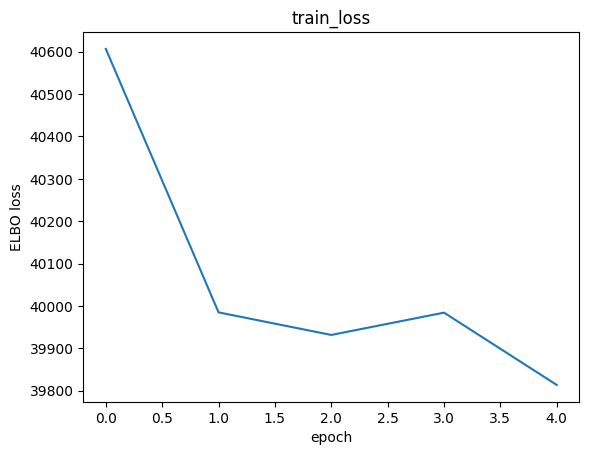

In [28]:
plt.plot(losses)
plt.title('train_loss')
plt.xlabel('epoch')
plt.ylabel('ELBO loss')
plt.show()

Inference

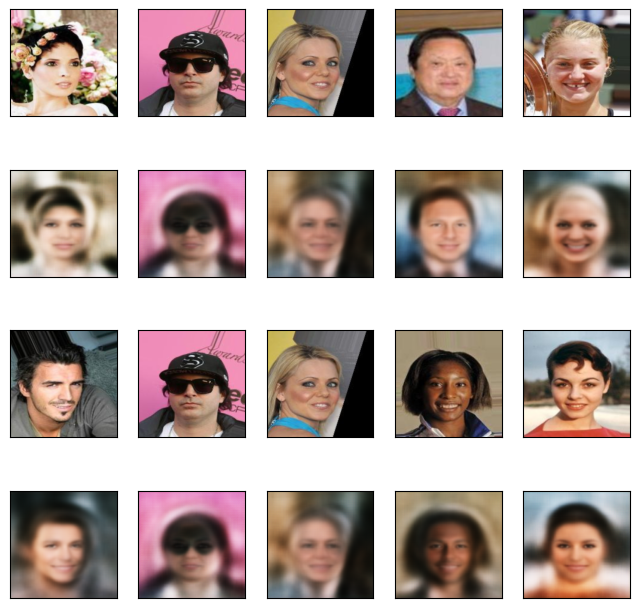

In [29]:
#Printing a random subset of training dataset along with the labels

with torch.no_grad():

    for images, _ in train_loader:
      fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(8,8))

      vae.cpu()
      vae.eval()
      recons = vae(images)

      for i in range(4):

        if i%2==0:
            idxs = np.random.randint(images.shape[0], size=5)

        for j in range(5):

          idx = idxs[j]

          if i%2==0:
              img = images[idx]
          else:
              img = recons[idx].detach()

          ax[i,j].imshow(img.permute(1, 2, 0))
          ax[i,j].axes.yaxis.set_visible(False)
          ax[i,j].axes.xaxis.set_visible(False)
      break

plt.show()

Generative

Image generation from random latent vectors sampled from the multivariate standard normal distribution.

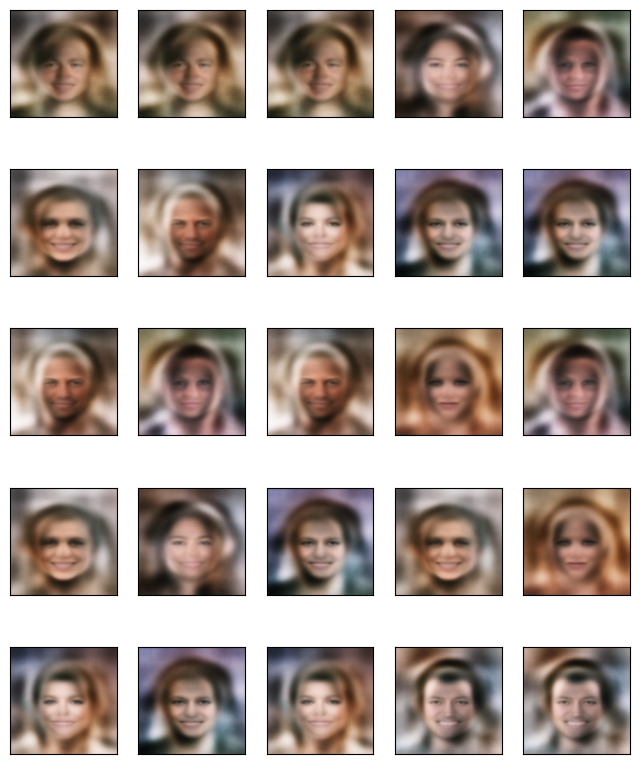

In [30]:
vae.cpu()
vae.eval()

with torch.no_grad():

    z = torch.randn(10, 100) # standard normal distribution

    generated_images = vae.decoder(z)

    #Printing a random subset of training dataset along with the labels
    fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(8,10))
    for i in range(5):
      for j in range(5):
        idx = np.random.randint(len(generated_images))
        img = generated_images[idx]
        ax[i,j].imshow(img.permute(1, 2, 0))
        ax[i,j].axes.yaxis.set_visible(False)
        ax[i,j].axes.xaxis.set_visible(False)

plt.show()